In [2]:
! wget -O images.zip https://figshare.com/ndownloader/articles/22987292/versions/3

--2024-12-02 20:27:37--  https://figshare.com/ndownloader/articles/22987292/versions/3
Resolving figshare.com (figshare.com)... 54.228.103.118, 34.252.194.191, 2a05:d018:1f4:d003:5690:ce60:6925:7a1e, ...
Connecting to figshare.com (figshare.com)|54.228.103.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627458376 (2.4G) [application/zip]
Saving to: ‘images.zip’

images.zip          100%[===================>]   2.45G  25.0MB/s    in 1m 48s  

2024-12-02 20:29:26 (23.2 MB/s) - ‘images.zip’ saved [2627458376/2627458376]



Download the dataset for rice: https://doi.org/10.6084/m9.figshare.22987292.v3
<br>
This contains the images for both train and test along with the relevant mask for the dataset. The XML file contains the properties for each image which can be identified based on the filename.

In [3]:
! unzip images.zip

Archive:  images.zip
 extracting: rice.zip                
 extracting: rice.xml                


In [4]:
! unzip rice.zip

Streaming output truncated to the last 5000 lines.
  inflating: rice/mask/Grainset_rice_2022-04-25-21-31-52_1_p600s.png  
  inflating: rice/mask/Grainset_rice_2021-07-05-18-19-43_4_p600s.png  
  inflating: rice/mask/Grainset_rice_2020-12-25-18-36-41_2_p600s.png  
  inflating: rice/mask/Grainset_rice_2020-06-04-21-27-46_2_p600s.png  
  inflating: rice/mask/Grainset_rice_2022-01-29-15-46-12_1_p600s.png  
  inflating: rice/mask/Grainset_rice_2020-07-08-22-48-43_3_p600s.png  
  inflating: rice/mask/Grainset_rice_2021-10-17-20-58-58_5_p600s.png  
  inflating: rice/mask/Grainset_rice_2022-02-24-14-12-53_0_p600s.png  
  inflating: rice/mask/Grainset_rice_2020-12-29-13-05-47_0_p600s.png  
  inflating: rice/mask/Grainset_rice_2022-08-19-21-28-45_0_p600s.png  
  inflating: rice/mask/Grainset_rice_2020-12-17-16-42-26_1_p600s.png  
  inflating: rice/mask/Grainset_rice_2022-11-08-21-14-39_1_p600s.png  
  inflating: rice/mask/Grainset_rice_2020-10-08-09-09-20_1_p600s.png  
  inflating: rice/mask/Gra

In [16]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xml.etree.ElementTree as ET
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import History
from sklearn.preprocessing import LabelEncoder

In [5]:
def count_files_in_folder(folder_path):
  # Count the number of files in the folder
  return sum([len(files) for _, _, files in os.walk(folder_path)])

In [6]:
# Example usage
for folder_path in ['/content/rice/mask','/content/rice/test','/content/rice/train']:
  print(f"Number of files in the folder: {count_files_in_folder(folder_path)}")

Number of files in the folder: 30962
Number of files in the folder: 3100
Number of files in the folder: 27862


The XML file in this dataset stores the NORMAL DU_grain category and 6 other categories that indicates the damage level of the grains.

In [9]:
def parse_rice_xml(file_path):
  # Parse the XML file
  tree = ET.parse(file_path)
  root = tree.getroot()

  # Initialize a list to store grain information
  grains = []

  # Loop through each <object> element
  for obj in root.findall('object'):
    grain = {
      "ID": obj.find('ID').text,
      "species": obj.find('species').text,
      "sub-species": obj.find('sub-species').text,
      "location": obj.find('location').text,
      "time": obj.find('time').text,
      "size": int(obj.find('size').text),
      "DU_grain": obj.find('DU_grain').text,
      "weight": int(obj.find('weight').text),
    }
    grains.append(grain)

  return grains

In [8]:
file_path = "/content/rice.xml"
grains_data = parse_rice_xml(file_path)
for grain in grains_data:
    print(grain)

Streaming output truncated to the last 5000 lines.
{'ID': 'Grainset_rice_2021-07-27-18-04-27_3_p600s', 'species': 'rice', 'sub-species': 'Long', 'location': 'CN', 'time': '2016-02-03', 'size': 11, 'DU_grain': 'NOR', 'weight': 23}
{'ID': 'Grainset_rice_2020-05-04-14-19-43_11_p600s', 'species': 'rice', 'sub-species': 'Wuchang', 'location': 'CN', 'time': '2020-04-19', 'size': 11, 'DU_grain': 'NOR', 'weight': 22}
{'ID': 'Grainset_rice_2020-06-07-16-48-41_1_p600s', 'species': 'rice', 'sub-species': 'Long', 'location': 'CN', 'time': '2017-09-19', 'size': 11, 'DU_grain': 'NOR', 'weight': 22}
{'ID': 'Grainset_rice_2021-09-16-17-37-17_2_p600s', 'species': 'rice', 'sub-species': 'Wuchang', 'location': 'CN', 'time': '2016-12-03', 'size': 11, 'DU_grain': 'NOR', 'weight': 24}
{'ID': 'Grainset_rice_2022-04-15-08-53-56_5_p600s', 'species': 'rice', 'sub-species': 'Wuchang', 'location': 'CN', 'time': '2018-03-08', 'size': 11, 'DU_grain': 'NOR', 'weight': 20}
{'ID': 'Grainset_rice_2022-08-10-13-07-51_0_

In [10]:
# Extract all DU_grain values
du_grain_values = [grain["DU_grain"] for grain in grains_data]

# Count occurrences of each unique value
du_grain_counts = Counter(du_grain_values)

# Print the counts
for value, count in du_grain_counts.items():
  print(f"DU_grain: {value}, Count: {count}")

DU_grain: BN, Count: 1491
DU_grain: SD, Count: 1500
DU_grain: AP, Count: 1500
DU_grain: F&S, Count: 1486
DU_grain: UN, Count: 1485
DU_grain: IM, Count: 2000
DU_grain: NOR, Count: 20000
DU_grain: MY, Count: 1500


In the above data the following is what is meant by the DU_grain types:
* NOR: Normal. These are grains that has not undergone any sprouting and are in good condition.
* IM: Impurities. Indicates those grains with some level of impurities and therefore cannot be used for consumption.
* F&S: Fusarium & Shriveled. These are grains that have been affected by fungi belonging to the Fusarium genus.
* SD: Sprouted. These are grains which have sprouted and therefore germination has already begun and so is not the best choice for consumption.
* MY: Moldy grains which have been affected by mold and fungi and therefore cannot be consumed.
* BN: Broken Grain. Grains that are fractured or damaged during the harvesting process.
* AP: Refers to grains that have been infested by insects.
* UN: Unripe Grain. These are the grains that have not fully riped and therefore has not reached it's full potential.
<br><br>
**The classification process should classify a given grain into one of the following above categories.**

In [21]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def visualize_images_and_masks(base_image_dir, mask_dir, sample_size=5, target_size=(128, 128)):
  """
  Visualize images and their corresponding masks from the given directories.

  :param base_image_dir: Path to the base directory containing train/test folders.
  :param mask_dir: Path to the directory containing the masks.
  :param sample_size: Number of images and masks to visualize.
  :param target_size: Tuple for resizing images and masks (height, width).
  """
  # Collect all image paths and corresponding class names
  image_paths = []
  for class_folder in os.listdir(base_image_dir):
    class_path = os.path.join(base_image_dir, class_folder)
    if os.path.isdir(class_path):
      for image_file in os.listdir(class_path):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
          image_paths.append((os.path.join(class_path, image_file), image_file))

  if not image_paths:
    print(f"No images found in {base_image_dir}. Please check the directory structure.")
    return

  # Limit the number of samples
  selected_samples = image_paths[:sample_size]

  for image_path, filename in selected_samples:
    mask_path = os.path.join(mask_dir, filename)

    if os.path.isfile(image_path) and os.path.isfile(mask_path):
      try:
        # Load and preprocess the image and mask
        image = load_img(image_path, target_size=target_size)
        mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")

        # Convert images to arrays
        image_array = img_to_array(image) / 255.0  # Normalize image
        mask_array = img_to_array(mask) / 255.0   # Normalize mask

        # Plot the image and corresponding mask
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image_array)
        plt.title(f"Image: {filename}")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask_array.squeeze(), cmap="gray")
        plt.title(f"Mask: {filename}")
        plt.axis("off")

        plt.show()
      except Exception as e:
        print(f"Error visualizing {filename}: {e}")
    else:
      print(f"Mask for {filename} not found in {mask_dir}. Skipping.")

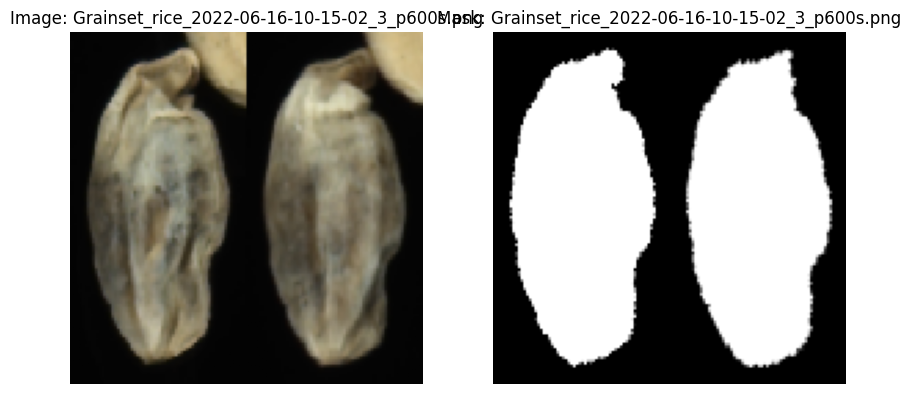

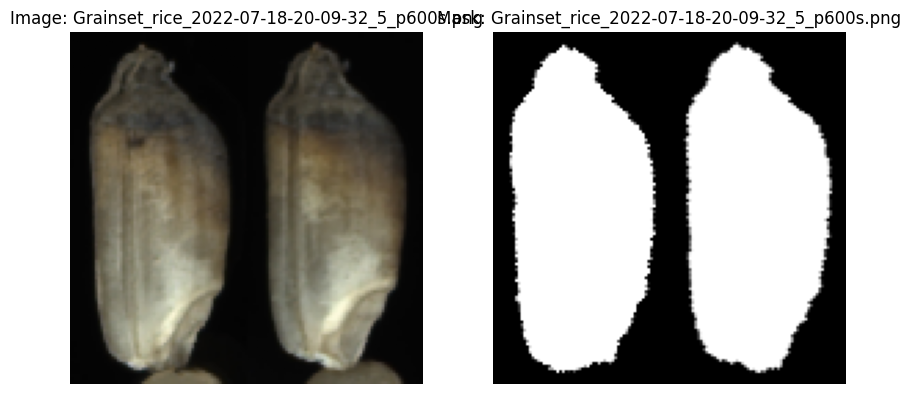

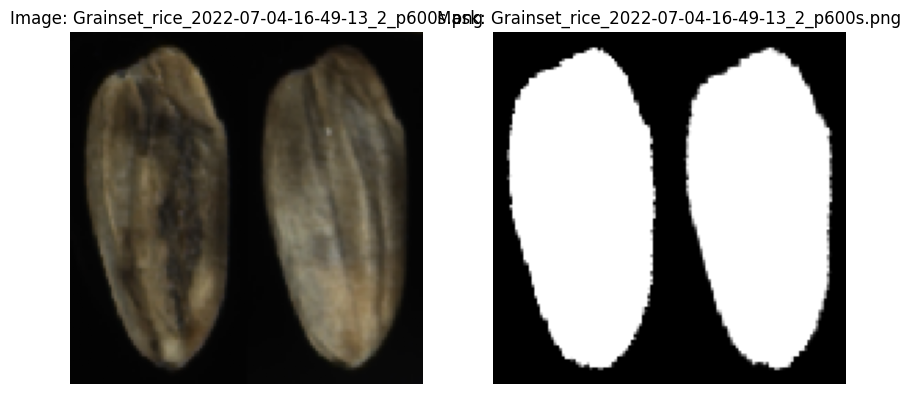

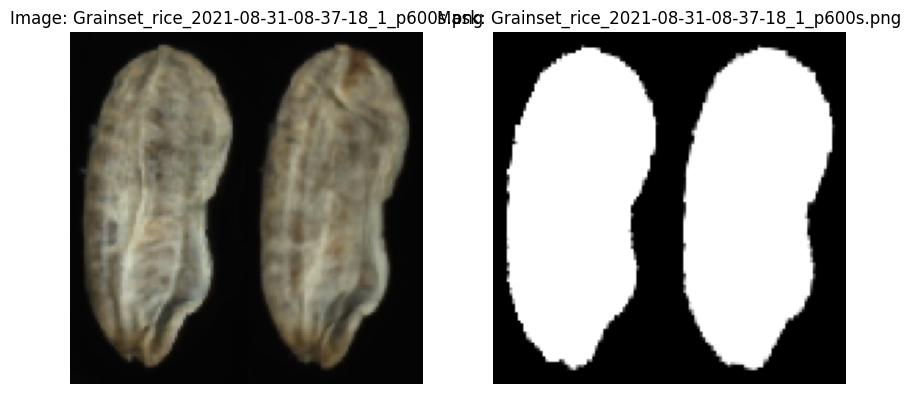

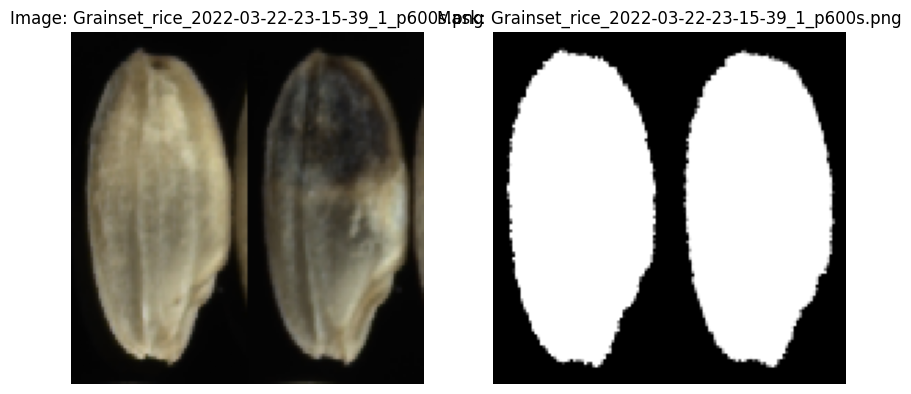

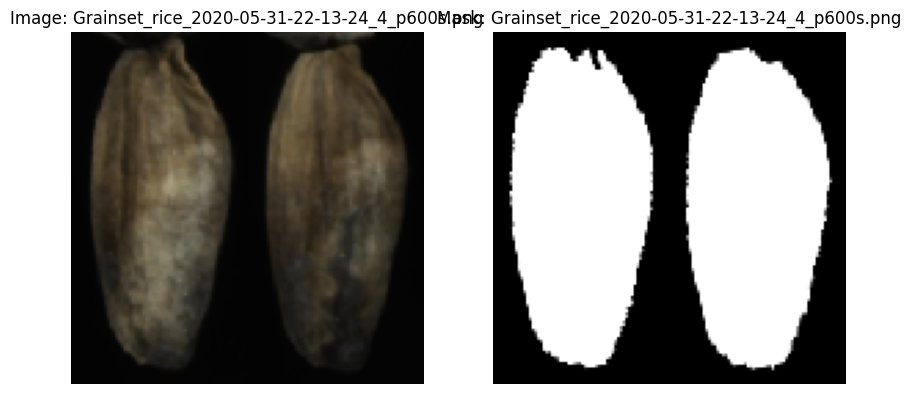

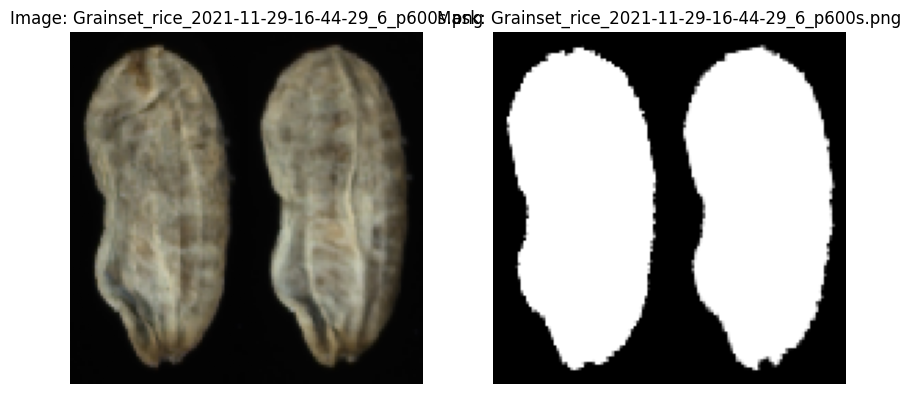

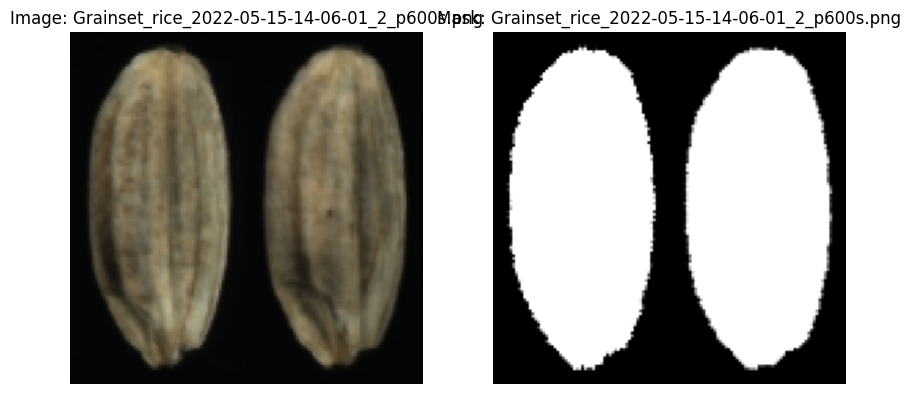

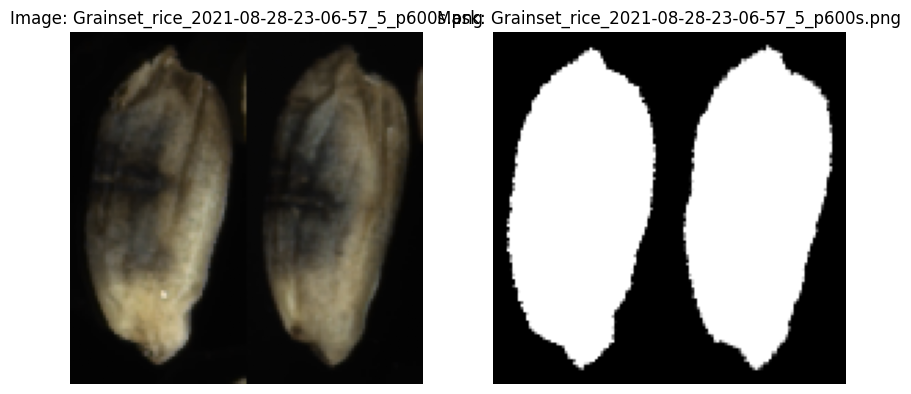

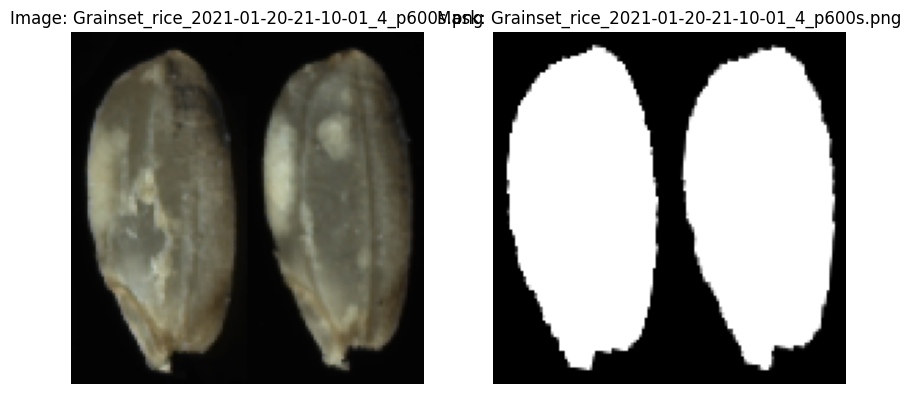

In [22]:
visualize_images_and_masks("/content/rice/train", "/content/rice/mask", sample_size=5, target_size=(128, 128))
visualize_images_and_masks("/content/rice/test", "/content/rice/mask", sample_size=5, target_size=(128, 128))

# Segmentation
As the first step we perform segmentation which involves being able to generate the mask of the image given the dataset. This is required to properly highlight only the area of interest which is the rice grain. The mask can then be applied on the image and then the rice grain with mask applied is used for classification.

In [23]:
def load_segmentation_data(base_image_dir, mask_dir, target_size=(128, 128)):
  """
  Load images and their corresponding masks based on the folder structure.

  :param base_image_dir: Path to the base directory containing train/test folders.
  :param mask_dir: Path to the directory containing the masks.
  :param target_size: Tuple for resizing images and masks (height, width).
  :return: Arrays of images and corresponding masks.
  """
  images = []
  masks = []

  for class_folder in os.listdir(base_image_dir):
    class_path = os.path.join(base_image_dir, class_folder)
    if os.path.isdir(class_path):
      for image_file in os.listdir(class_path):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
          image_path = os.path.join(class_path, image_file)
          mask_path = os.path.join(mask_dir, image_file)

          if os.path.isfile(image_path) and os.path.isfile(mask_path):
            # Load and preprocess the image and mask
            img = load_img(image_path, target_size=target_size)
            mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")

            # Convert to arrays
            images.append(img_to_array(img) / 255.0)  # Normalize image
            masks.append(img_to_array(mask) / 255.0)  # Normalize mask

  return np.array(images), np.array(masks)

In [ ]:
# Load train and test data
train_images, train_masks = load_segmentation_data("/content/rice/train", "/content/rice/mask")
test_images, test_masks = load_segmentation_data("/content/rice/test", "/content/rice/mask")

In [ ]:
# Split train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

In [ ]:
def unet_model(input_shape=(128, 128, 3)):
    """
    Define a U-Net model for segmentation.

    :param input_shape: Shape of the input images (height, width, channels).
    :return: U-Net model.
    """
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Decoder
    u1 = UpSampling2D((2, 2))(c3)
    u1 = concatenate([u1, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u2 = UpSampling2D((2, 2))(c4)
    u2 = concatenate([u2, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    return Model(inputs, outputs)

# Initialize and compile the model
seg_model = unet_model()
seg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
seg_history = seg_model.fit(
    X_train, y_train[..., np.newaxis],  # Add channel dimension to masks
    validation_data=(X_val, y_val[..., np.newaxis]),
    epochs=10,
    batch_size=16
)

In [ ]:
# Predict on test data
test_preds = seg_model.predict(test_images)

# Compute IoU
iou_metric = MeanIoU(num_classes=2)
iou_metric.update_state(test_masks[..., np.newaxis], test_preds)
print(f"IoU: {iou_metric.result().numpy()}")

# Dice Score
def dice_score(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

dice = dice_score(test_masks, test_preds)
print(f"Dice Score: {dice}")

## Classification
Next step is to build a classification model.

In [ ]:
def load_classification_data(base_image_dir, grains_data, target_size=(128, 128)):
    """
    Load images and their corresponding classification labels.

    :param base_image_dir: Path to the base directory containing train/test folders.
    :param grains_data: List of grain metadata with IDs and DU_grain labels.
    :param target_size: Tuple for resizing images (height, width).
    :return: Arrays of images and their labels.
    """
    images = []
    labels = []
    grain_dict = {grain['ID']: grain['DU_grain'] for grain in grains_data}

    for class_folder in os.listdir(base_image_dir):
        class_path = os.path.join(base_image_dir, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_id = os.path.splitext(image_file)[0]
                    image_path = os.path.join(class_path, image_file)

                    if image_id in grain_dict:
                        # Load and preprocess the image
                        img = load_img(image_path, target_size=target_size)
                        images.append(img_to_array(img) / 255.0)  # Normalize image
                        labels.append(grain_dict[image_id])

    return np.array(images), np.array(labels)

# Load train and test data
train_images_cls, train_labels_cls = load_classification_data("train", grains_data)
test_images_cls, test_labels_cls = load_classification_data("test", grains_data)

# Convert class labels to numerical format using LabelEncoder
label_encoder = LabelEncoder()
train_labels_cls = label_encoder.fit_transform(train_labels_cls)
test_labels_cls = label_encoder.transform(test_labels_cls)

In [ ]:
def build_classification_model(input_shape=(128, 128, 3), num_classes=3):
    """
    Define a simple CNN model for classification.

    :param input_shape: Shape of the input images (height, width, channels).
    :param num_classes: Number of unique classes.
    :return: Classification model.
    """
    inputs = Input(input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

# Initialize and compile the model
num_classes = len(label_encoder.classes_)
cls_model = build_classification_model(num_classes=num_classes)
cls_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cls_history = cls_model.fit(
    train_images_cls, train_labels_cls,
    validation_split=0.2, epochs=10, batch_size=16, verbose=1
)

In [ ]:
cls_preds = cls_model.predict(test_images_cls)
cls_preds_labels = np.argmax(cls_preds, axis=1)

print(classification_report(test_labels_cls, cls_preds_labels, target_names=label_encoder.classes_))